In [1]:
!unzip '/content/drive/MyDrive/File Submission/Book_Recomendations.zip' -d Book_Recomendations

Archive:  /content/drive/MyDrive/File Submission/Book_Recomendations.zip
  inflating: Book_Recomendations/Books.csv  
  inflating: Book_Recomendations/DeepRec.png  
  inflating: Book_Recomendations/Ratings.csv  
  inflating: Book_Recomendations/Users.csv  
  inflating: Book_Recomendations/classicRec.png  
  inflating: Book_Recomendations/recsys_taxonomy2.png  


1. Import Library

In [115]:
import pandas as pd              # Untuk manipulasi data
import numpy as np               # Untuk operasi numerik
import matplotlib.pyplot as plt  # Untuk visualisasi (optional)
import seaborn as sns            # Visualisasi data (optional)
from sklearn.feature_extraction.text import TfidfVectorizer  # NLP - vectorizer
from sklearn.metrics.pairwise import cosine_similarity       # Hitung kemiripan antar vektor
import re                          # Untuk preprocessing teks (regex)
import string                      # Untuk hapus tanda baca
from sklearn.metrics.pairwise import linear_kernel
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.neighbors import NearestNeighbors
from IPython.display import Image, display
from collections import defaultdict

2. Load semua dari dataset

In [3]:
df_book = pd.read_csv('/content/Book_Recomendations/Books.csv', low_memory=False)

In [4]:
df_Ratings = pd.read_csv('/content/Book_Recomendations/Ratings.csv')

In [5]:
df_Users = pd.read_csv('/content/Book_Recomendations/Users.csv')

# **Data Understanding**
### BOOKS
Menampilkan 5 baris pertama dari dataset

In [ ]:
df_book.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Menampilkan Jumlah baris dan kolom pada dataset Books.csv

In [ ]:
print("Number of rows:", df_book.shape[0])
print("Number of columns:", df_book.shape[1])

Number of rows: 271360
Number of columns: 8


Melihat Fitur yang ada pada dataset Books.csv
check tipe dari setiap data, missing value dan data duplikat.

ditemukan missing value pada:

Book-Author :           2

Publisher :             2

Image-URL-L   :         3

In [ ]:
# Display all available features (columns)
print("Available Features:\n", df_book.columns.tolist())

# Check data types of each feature
print("\nData Types:\n", df_book.dtypes)

# Check for missing values
print("\nMissing Values:\n", df_book.isnull().sum())

# Check for duplicate rows
print("\nNumber of Duplicate Rows:", df_book.duplicated().sum())


Available Features:
 ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']

Data Types:
 ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication    object
Publisher              object
Image-URL-S            object
Image-URL-M            object
Image-URL-L            object
dtype: object

Missing Values:
 ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

Number of Duplicate Rows: 0


Melihat apakah ada outlier pada data Year-Of-Publication

Terdapat Outlier dimana buku di publish melebihi waktu sekarang dan juga sebelum tahun 1980, seperti tahun 0 atau sebelum 1500.

Number of low outliers: 0
Number of high outliers: 5
Total number of outliers: 5


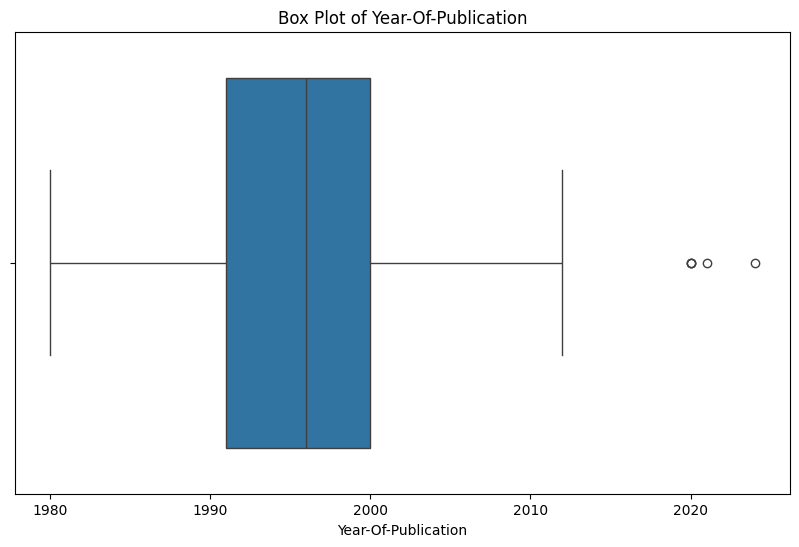

count    251265.000000
mean       1994.965542
std           6.183895
min        1980.000000
25%        1991.000000
50%        1996.000000
75%        2000.000000
max        2024.000000
Name: Year-Of-Publication, dtype: float64


In [ ]:
# Calculate quartiles (Q1, Q3) and IQR
Q1 = df_book['Year-Of-Publication'].quantile(0.25)
Q3 = df_book['Year-Of-Publication'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Count outliers
outliers_low = df_book[(df_book['Year-Of-Publication'] < lower_bound)]
outliers_high = df_book[(df_book['Year-Of-Publication'] > upper_bound)]
total_outliers = len(outliers_low) + len(outliers_high)


print(f"Number of low outliers: {len(outliers_low)}")
print(f"Number of high outliers: {len(outliers_high)}")
print(f"Total number of outliers: {total_outliers}")

# Melihat apakah ada outlier pada data Year-Of-Publication
plt.figure(figsize=(10, 6))
sns.boxplot(x='Year-Of-Publication', data=df_book)
plt.title('Box Plot of Year-Of-Publication')
plt.show()

# Alternative method using describe() to identify potential outliers
print(df_book['Year-Of-Publication'].describe())


### **USER**

Dilakukan pengecekan juga ada pada Dataset User.

In [ ]:
df_Users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


Melihat jumlah baris data dan kolom pada dataset Users

In [ ]:
print("Number of rows:", df_Users.shape[0])
print("Number of columns:", df_Users.shape[1])

Number of rows: 278858
Number of columns: 3


Melihat Fitur, tipe data, missing value, dan duplikat data.

dimana disini ditemukan 110762 missing values pada data Age, yang hal ini sering ditemukan karena beberapa orang memilih tidak memberitahukan umurnya.

In [ ]:
# Display all available features (columns)
print("Available Features:\n", df_Users.columns.tolist())

# Check data types of each feature
print("\nData Types:\n", df_Users.dtypes)

# Check for missing values
print("\nMissing Values:\n", df_Users.isnull().sum())

# Check for duplicate rows
print("\nNumber of Duplicate Rows:", df_Users.duplicated().sum())

Available Features:
 ['User-ID', 'Location', 'Age']

Data Types:
 User-ID       int64
Location     object
Age         float64
dtype: object

Missing Values:
 User-ID          0
Location         0
Age         110762
dtype: int64

Number of Duplicate Rows: 0


Melihat apakah ada Outlier pada data Age.

Disini dapat dilihat terdapat beberapa Outlier (Umur yang tidak wajar) dari min 0 dan nilai Max 244.


Age Statistics:
 count    168096.000000
mean         34.751434
std          14.428097
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max         244.000000
Name: Age, dtype: float64


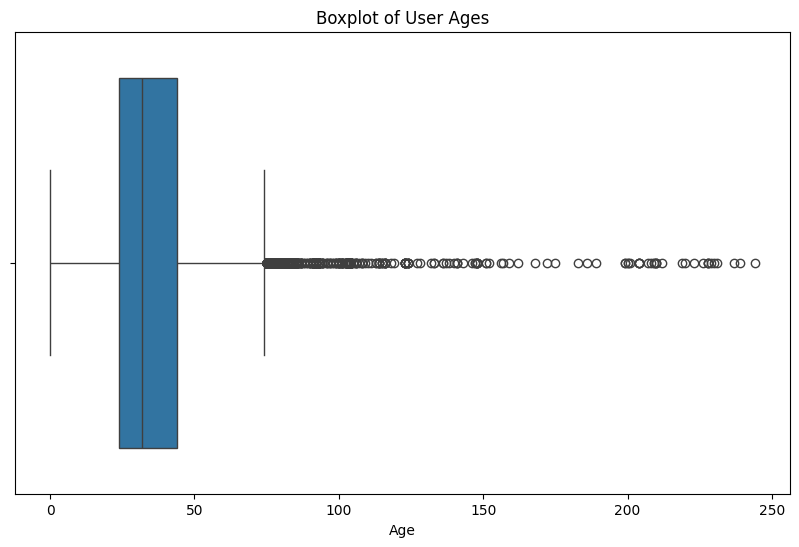

In [ ]:
# Check for outliers in 'Age' column of df_Users
print("\nAge Statistics:\n", df_Users['Age'].describe())

# Visualize the distribution of 'Age'
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_Users['Age'])
plt.title('Boxplot of User Ages')
plt.show()

melihat data yang dinilai Outlier dengan IQR method

In [6]:
# Identify outliers using IQR method
Q1 = df_Users['Age'].quantile(0.25)
Q3 = df_Users['Age'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_Users[(df_Users['Age'] < lower_bound) | (df_Users['Age'] > upper_bound)]
print("\nNumber of outliers in 'Age':", len(outliers))
print("\nOutliers:\n", outliers)


Number of outliers in 'Age': 1084

Outliers:
         User-ID                                      Location    Age
220         221                      palm beach, florida, usa   79.0
689         690                      lake oswego, oregon, usa   80.0
957         958                           lindale, texas, usa   78.0
1147       1148                  prairie village, kansas, usa   79.0
1288       1289                     san jose, california, usa  103.0
...         ...                                           ...    ...
278301   278302      düsseldorf, nordrhein-westfalen, germany  104.0
278317   278318                  studio city, california, usa   77.0
278348   278349                           carlin, nevada, usa   76.0
278412   278413                    kansas city, missouri, usa   76.0
278471   278472  biel-benken bl/schweiz, alabama, switzerland   81.0

[1084 rows x 3 columns]


### **RATING**

dilakukan pengecekan yang sama pada data Rating

In [ ]:
df_Ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Melihat Jumlah bari dan kolom pada dataset Ratings

In [ ]:
print("Number of rows:", df_Ratings.shape[0])
print("Number of columns:", df_Ratings.shape[1])

Number of rows: 1149780
Number of columns: 3


Melihat semua Fitur pada dataset, Jenis tipe data, missing value dan Duplikat. yang dimana tidak ditemukan disini.

In [ ]:
# Display all available features (columns)
print("Available Features:\n", df_Ratings.columns.tolist())

# Check data types of each feature
print("\nData Types:\n", df_Ratings.dtypes)

# Check for missing values
print("\nMissing Values:\n", df_Ratings.isnull().sum())

# Check for duplicate rows
print("\nNumber of Duplicate Rows:", df_Ratings.duplicated().sum())

Available Features:
 ['User-ID', 'ISBN', 'Book-Rating']

Data Types:
 User-ID         int64
ISBN           object
Book-Rating     int64
dtype: object

Missing Values:
 User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Number of Duplicate Rows: 0


# **Exploratory Data Analyst (EDA)**

Melihat Publisher yang mempublish buku terbanyak pada dataset ini, yaitu :

Harlequin	7535

Silhouette	4220

Pocket	3905

Ballantine Books	3783

Bantam Books

In [ ]:
df_book['Publisher'].value_counts()

,count
Publisher,
Harlequin,7535
Silhouette,4220
Pocket,3905
Ballantine Books,3783
Bantam Books,3646
...,...
Scholastic (An Apple Paperback),1
Spencer Butte Press,1
Kowalski,1


Melihat Author yang memiliki buku terbanyak pada dataset ini, yaitu :

Agatha Christie	632

William Shakespeare	567

Stephen King	524

Ann M. Martin	423

Carolyn Keene	373

In [ ]:
df_book['Book-Author'].value_counts()

,count
Book-Author,
Agatha Christie,632
William Shakespeare,567
Stephen King,524
Ann M. Martin,423
Carolyn Keene,373
...,...
JÃ¶rn Kalkbrenner,1
Paul A. Lynn,1
Arthur Bernard Williams,1


Melihat Distribusi dari Ratings.

dimana disini Rating 0 adalah tidak memberikan penilaian terhadap bukunya.

count    1.149780e+06
mean     2.866950e+00
std      3.854184e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      7.000000e+00
max      1.000000e+01
Name: Book-Rating, dtype: float64


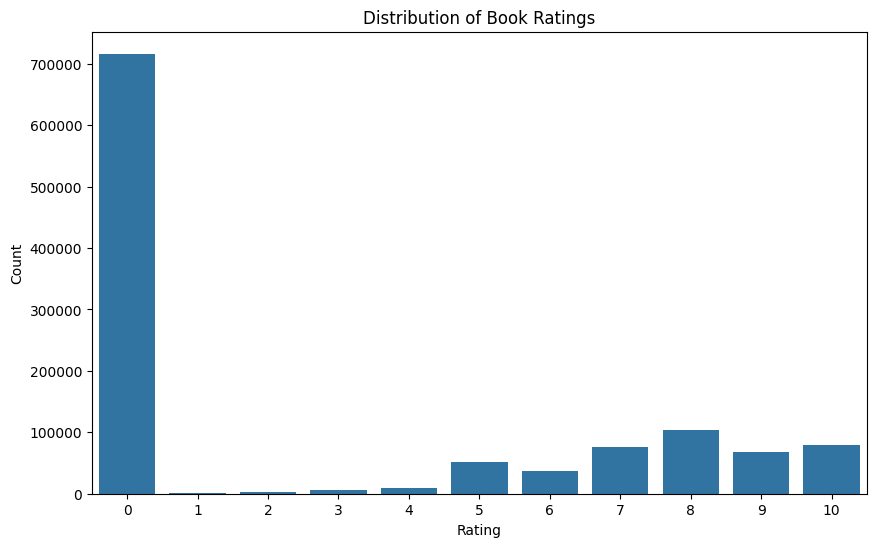

In [ ]:
# Check the distribution of ratings
print(df_Ratings['Book-Rating'].describe())

# Visualize the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(x='Book-Rating', data=df_Ratings)
plt.title('Distribution of Book Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


Melihat Buku yang paling banyak di Rating oleh User, yaitu :

Wild Animus        2502.0

The Lovely Bones: A Novel        1295.0

The Da Vinci Code         883.0

Divine Secrets of the Ya-Ya Sisterhood: A Novel         732.0

The Red Tent (Bestselling Backlist)         723.0

In [ ]:
# Calculate the popularity of books based on the number of ratings
book_popularity = df_Ratings.groupby('ISBN')['Book-Rating'].count().reset_index()
book_popularity.rename(columns={'Book-Rating': 'Rating_Count'}, inplace=True)

# Merge popularity data with book information
df_merged = pd.merge(df_book, book_popularity, on='ISBN', how='left')

# Sort books by rating count in descending order and get the top 10
top_10_books = df_merged.sort_values(by='Rating_Count', ascending=False).head(10)

# Display the top 10 books with their titles and rating counts
print(top_10_books[['Book-Title', 'Rating_Count']])


                                             Book-Title  Rating_Count
26                                          Wild Animus        2502.0
408                           The Lovely Bones: A Novel        1295.0
748                                   The Da Vinci Code         883.0
1105    Divine Secrets of the Ya-Ya Sisterhood: A Novel         732.0
522                 The Red Tent (Bestselling Backlist)         723.0
305                                     A Painted House         647.0
356                             The Secret Life of Bees         615.0
1922                             Snow Falling on Cedars         614.0
118                                 Angels &amp; Demons         586.0
706   Where the Heart Is (Oprah's Book Club (Paperba...         585.0


User teraktif yang memberikan Rating, yaitu user dengan Id 11676

In [ ]:
top_active_user = df_Ratings['User-ID'].value_counts().idxmax()
print(f"The most active user is: {top_active_user}")

The most active user is: 11676


Melihat Negara dengan Jumlah User terbanyak, dimana disini dapat dilihat USA menepati nomor datu, kemudian Canada dan setelahnya UK.

<ipython-input-14-1a292545f90a>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')


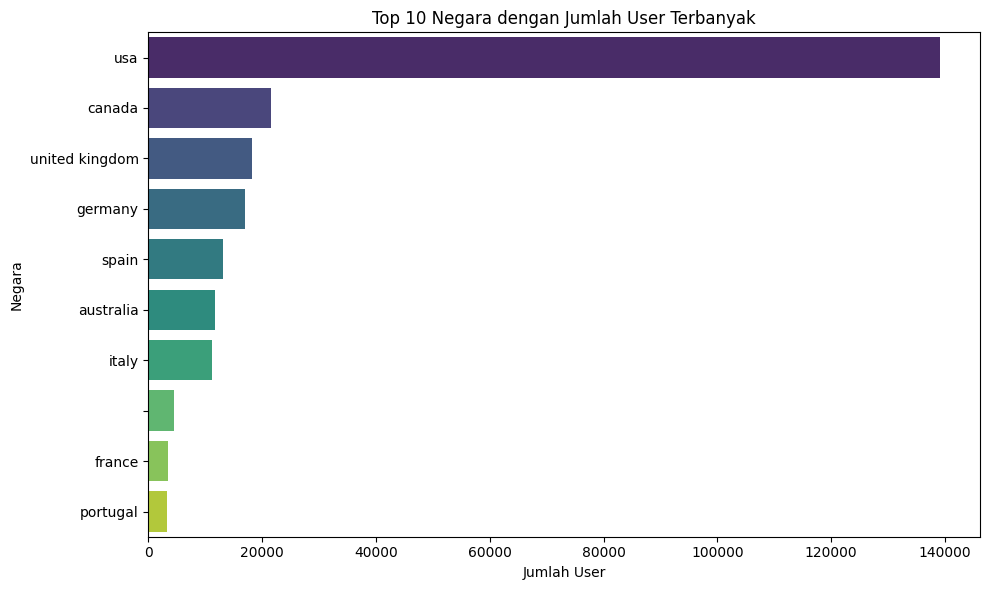

In [ ]:
# Pisahkan kolom location menjadi kota, negara bagian, negara
df_Users[['city', 'state', 'country']] = df_Users['Location'].str.split(',', expand=True, n=2)
df_Users['country'] = df_Users['country'].str.strip()  # Hilangkan spasi

# Hitung jumlah user per negara
top_countries = df_Users['country'].value_counts().head(10)

# Plot top 10 negara dengan user terbanyak
plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette='viridis')
plt.title('Top 10 Negara dengan Jumlah User Terbanyak')
plt.xlabel('Jumlah User')
plt.ylabel('Negara')
plt.tight_layout()
plt.show()

Disini diperlihatkan untuk Distribusi Usia pengguna.


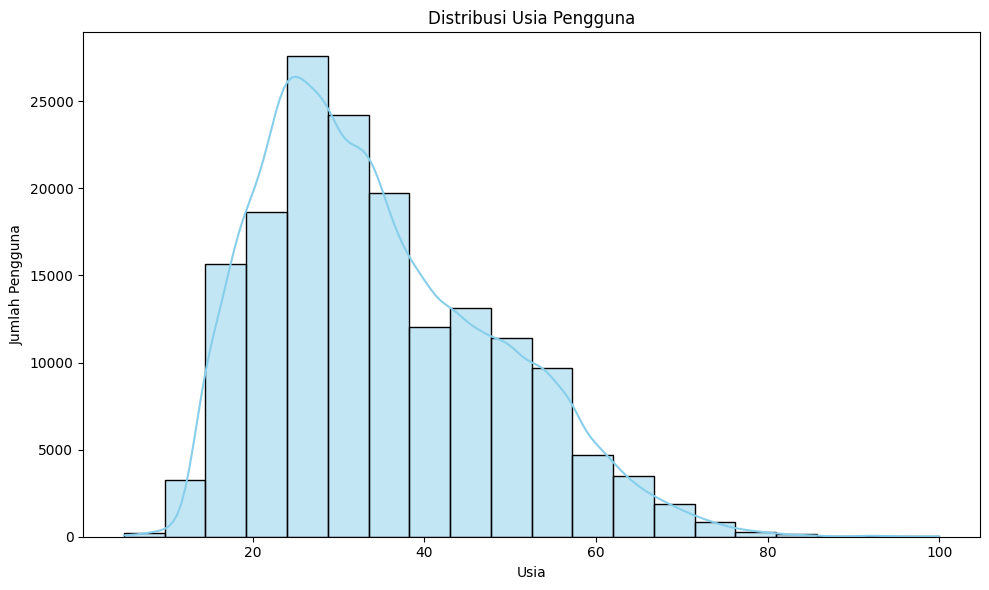

<ipython-input-8-9a166ff3d2cb>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users_clean['AgeGroup'] = pd.cut(df_users_clean['Age'], bins=bins, labels=labels, right=False)
<ipython-input-8-9a166ff3d2cb>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='coolwarm')


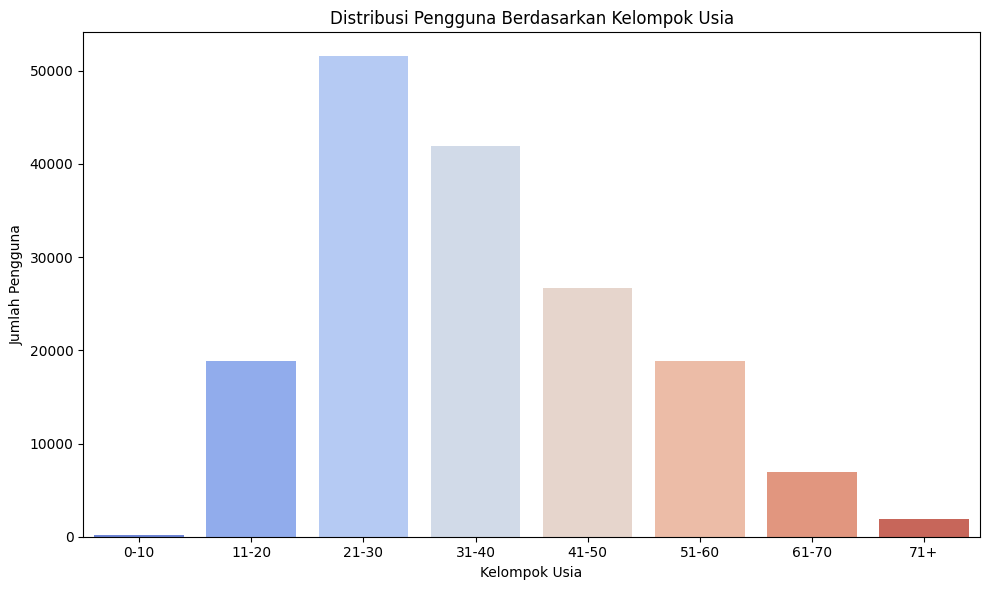

In [ ]:
# Filter usia valid (range 5 - 100 tahun)
df_users_clean = df_Users[(df_Users['Age'] >= 5) & (df_Users['Age'] <= 100)]

# Histogram distribusi usia
plt.figure(figsize=(10,6))
sns.histplot(df_users_clean['Age'], bins=20, kde=True, color='skyblue')
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah Pengguna')
plt.tight_layout()
plt.show()

# Tambahan: Plot distribusi kelompok usia
bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]
labels = ['0-10','11-20','21-30','31-40','41-50','51-60','61-70','71+']
df_users_clean['AgeGroup'] = pd.cut(df_users_clean['Age'], bins=bins, labels=labels, right=False)

age_group_counts = df_users_clean['AgeGroup'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=age_group_counts.index, y=age_group_counts.values, palette='coolwarm')
plt.title('Distribusi Pengguna Berdasarkan Kelompok Usia')
plt.xlabel('Kelompok Usia')
plt.ylabel('Jumlah Pengguna')
plt.tight_layout()
plt.show()


# **Data Preparation**

Penjelasan: Mengubah kolom tahun publikasi menjadi tipe numerik. Jika ada nilai tidak valid (misalnya teks), akan diubah jadi NaN.

Tujuan: Supaya bisa dianalisis atau difilter sebagai angka, bukan string.

In [7]:
df_book['Year-Of-Publication'] = pd.to_numeric(df_book['Year-Of-Publication'], errors='coerce')
print(df_book['Year-Of-Publication'].dtype)

float64


Penjelasan: Menghapus data buku dengan tahun publikasi yang tidak wajar (di luar 1980–2024).

Tujuan: Menghindari data outlier yang bisa mengganggu analisis atau rekomendasi (misalnya tahun 0 atau 9999).

In [8]:
df_book = df_book[(df_book['Year-Of-Publication'] >= 1980) & (df_book['Year-Of-Publication'] <= 2024)]
print(df_book['Year-Of-Publication'].describe())

count    251269.000000
mean       1994.965611
std           6.183879
min        1980.000000
25%        1991.000000
50%        1996.000000
75%        2000.000000
max        2024.000000
Name: Year-Of-Publication, dtype: float64


Penjelasan: Menghapus baris yang memiliki nilai kosong di kolom penting seperti penulis, penerbit, dan gambar.

Tujuan: Kolom ini penting untuk filtering konten dan tampilan aplikasi, jadi harus lengkap.

In [9]:
# Drop rows with missing values in 'Book-Author', 'Publisher', and 'Image-URL-M'
df_book.dropna(subset=['Book-Author', 'Publisher', 'Image-URL-L'], inplace=True)

# Verify the changes (optional)
print("\nMissing Values after dropping:\n", df_book.isnull().sum())
print("Number of rows after dropping missing values:", df_book.shape[0])



Missing Values after dropping:
 ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64
Number of rows after dropping missing values: 251265


Penjelasan: Menghapus data pengguna dengan umur yang tidak wajar berdasarkan batas bawah dan atas yang telah ditentukan.

Tujuan: Umur ekstrem atau tidak masuk akal bisa bias terhadap analisis demografi pengguna.

In [10]:
df_Users = df_Users[(df_Users['Age'] >= lower_bound) & (df_Users['Age'] <= upper_bound)]
print("\nNumber of rows after removing outliers:", len(df_Users))
print("\nAge Statistics:\n", df_Users['Age'].describe())


Number of rows after removing outliers: 167012

Age Statistics:
 count    167012.000000
mean         34.373590
std          13.517693
min           0.000000
25%          24.000000
50%          32.000000
75%          44.000000
max          74.000000
Name: Age, dtype: float64


Penjelasan: Menggabungkan tabel rating dengan user dan buku untuk mendapatkan data lengkap dalam satu tabel.

Tujuan: Collaborative Filtering membutuhkan informasi pengguna, buku, dan rating dalam satu struktur data.

In [11]:
# Gabung ratings dengan users
df_merged = df_Ratings.merge(df_Users, on='User-ID', how='left')

# Gabung hasilnya dengan books
df_merged = df_merged.merge(df_book, on='ISBN', how='left')

# Tampilkan dimensi awal
print("Jumlah data setelah merge:", df_merged.shape)


Jumlah data setelah merge: (1149780, 12)


Penjelasan: Menghapus rating 0, yang dianggap sebagai rating implisit atau tidak sah.

Tujuan: Collaborative Filtering biasanya menggunakan rating eksplisit (yang benar-benar diberikan pengguna).

In [12]:
# Hapus rating implisit (rating = 0)
df_merged = df_merged[df_merged['Book-Rating'] > 0]
print("Jumlah data setelah filter rating eksplisit:", df_merged.shape)

Jumlah data setelah filter rating eksplisit: (433671, 12)


Penjelasan: Menyaring hanya user dan buku yang muncul lebih dari satu kali.

Tujuan: Untuk meningkatkan kualitas data, karena interaksi tunggal sulit digunakan dalam Collaborative Filtering.

In [13]:
# Hitung frekuensi user dan buku
user_counts = df_merged['User-ID'].value_counts()
book_counts = df_merged['ISBN'].value_counts()

# Ambil hanya user dan buku yang muncul lebih dari 1 kali
df_merged = df_merged[
    df_merged['User-ID'].isin(user_counts[user_counts > 1].index) &
    df_merged['ISBN'].isin(book_counts[book_counts > 1].index)
]
print("Jumlah data setelah filter user & buku langka:", df_merged.shape)

Jumlah data setelah filter user & buku langka: (270604, 12)


Penjelasan: Membersihkan nilai usia ekstrem dan mengganti nilai kosong dengan -1 sebagai penanda "tidak diketahui".

Tujuan: Menghindari error saat analisis, dan tetap bisa mengenali pengguna yang tidak mengisi umur.

In [14]:
# Bersihkan nilai ekstrem terlebih dahulu
df_merged['Age'] = df_merged['Age'].apply(lambda x: x if 5 <= x <= 100 else None)

# Ganti missing value Age dengan -1 (menandakan Unknown)
df_merged['Age'].fillna(-1, inplace=True)

# Cek distribusi age setelah cleaning
print(df_merged['Age'].value_counts().head())

Age
-1.0     79184
 29.0     8195
 33.0     7758
 28.0     7251
 32.0     7193
Name: count, dtype: int64


<ipython-input-14-528ecaac11d6>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['Age'].fillna(-1, inplace=True)


Penjelasan: Mengambil hanya kolom penting untuk modeling dan mengganti nama kolom agar lebih ringkas.

Tujuan: Supaya data lebih siap dipakai dalam model Collaborative Filtering dan lebih mudah digunakan dalam coding.

In [15]:
# Ambil hanya kolom penting
df_model = df_merged[['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author']].copy()

# Rename kolom agar lebih pendek
df_model.columns = ['user_id', 'isbn', 'rating', 'title', 'author']

# **Modeling -- Collaborative Learning**

Penjelasan:

Reader() mendefinisikan rentang nilai rating, di sini dari 1 sampai 10.

load_from_df(...) mengubah DataFrame menjadi format yang bisa dibaca oleh Surprise.

Tujuan:
Agar data bisa digunakan oleh model Surprise yang membutuhkan format dan skala rating yang eksplisit.

In [16]:
# Format data sesuai Surprise
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(df_model[['user_id', 'isbn', 'rating']], reader)

Penjelasan:

Memisahkan data menjadi 80% untuk pelatihan dan 20% untuk pengujian.

Tujuan:
Untuk menguji performa model pada data yang belum pernah dilihat sebelumnya dan mencegah overfitting.

In [17]:
# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Penjelasan:

SVD() membuat objek model SVD.

fit(trainset) melatih model dengan data pelatihan.

Tujuan:
SVD mempelajari pola hubungan antara pengguna dan item (buku) berdasarkan data rating, dan menghasilkan representasi laten dari preferensi.

In [18]:
# Gunakan model SVD
model_svd = SVD()
model_svd.fit(trainset)

Penjelasan:

test(testset) melakukan prediksi rating terhadap data uji.

rmse(...) menghitung Root Mean Squared Error.

Tujuan:
Mengetahui seberapa jauh prediksi model dari rating asli. Semakin kecil RMSE, semakin baik modelnya.

In [19]:
# Prediksi
predictions = model_svd.test(testset)
# Evaluasi
print("RMSE:", accuracy.rmse(predictions))

RMSE: 1.6260
RMSE: 1.6259664841475066


Penjelasan:
Mengambil ID pengguna yang paling aktif (paling banyak memberi rating).

Tujuan:
Menampilkan contoh rekomendasi personalisasi untuk pengguna yang aktif.

In [20]:
# Pilih user
user_id = df_model['user_id'].value_counts().index[0]  # user teraktif

Penjelasan:

user_books: daftar buku yang sudah dibaca user.

all_books: semua ISBN unik di dataset.

books_to_predict: daftar ISBN yang belum dibaca user tersebut.

Tujuan:
Agar model merekomendasikan buku baru yang belum pernah dibaca user.



In [21]:

# Buku yang belum pernah dia baca
user_books = df_model[df_model['user_id'] == user_id]['isbn'].tolist()
all_books = df_model['isbn'].unique()
books_to_predict = [isbn for isbn in all_books if isbn not in user_books]


Penjelasan:

Prediksi rating untuk setiap buku yang belum dibaca user.

Sortir berdasarkan prediksi tertinggi (.est = estimated rating).

Tujuan:
Menemukan buku mana yang kemungkinan besar akan disukai user.



In [22]:

# Buat prediksi
predictions = [model_svd.predict(user_id, isbn) for isbn in books_to_predict]
predictions.sort(key=lambda x: x.est, reverse=True)


Penjelasan:

Ambil 5 buku teratas dengan rating tertinggi yang diprediksi.

Tampilkan judul, penulis, dan rating prediksi.

Tujuan:
Memberikan output rekomendasi buku personal untuk user aktif, yang bisa digunakan langsung di aplikasi rekomendasi.

In [23]:
# Ambil top-5
top_5 = predictions[:5]
for i, pred in enumerate(top_5):
    book_info = df_model[df_model['isbn'] == pred.iid].iloc[0]
    print(f"{i+1}. {book_info['title']} by {book_info['author']} - Predicted Rating: {pred.est:.2f}")

1. The Catcher in the Rye by J.D. Salinger - Predicted Rating: 10.00
2. Dilbert: A Book of Postcards by Scott Adams - Predicted Rating: 10.00
3. What Dreams May Come : A Novel by Richard Matheson - Predicted Rating: 9.84
4. Bel Canto: A Novel by Ann Patchett - Predicted Rating: 9.84
5. Richtig leben mit Geri Weibel. by Martin Suter - Predicted Rating: 9.73


In [223]:
def get_top_n_svd(predictions, n=5):
    """
    Ambil top-N rekomendasi untuk setiap user dari prediksi SVD
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for (iid, _) in user_ratings[:n]]

    return top_n

def precision_recall_at_k_svd(predictions, k=5, threshold=7.0):
    """
    Evaluasi precision@k dan recall@k berdasarkan prediksi SVD
    """
    user_est_true = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, est, true_r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        # Relevan jika true rating >= threshold
        relevant_items = [iid for (iid, _, true_r) in user_ratings if true_r >= threshold]
        recommended_items = [iid for (iid, est, _) in sorted(user_ratings, key=lambda x: x[1], reverse=True)[:k]]

        if not relevant_items:
            continue

        hit_set = set(recommended_items) & set(relevant_items)
        precision = len(hit_set) / k
        recall = len(hit_set) / len(relevant_items)

        precisions.append(precision)
        recalls.append(recall)

    return sum(precisions) / len(precisions), sum(recalls) / len(recalls)

# Prediksi dari model SVD (gunakan model_svd yang telah dilatih sebelumnya)
predictions = model_svd.test(testset)
top_n_svd = get_top_n_svd(predictions, n=5)
precision_svd, recall_svd = precision_recall_at_k_svd(predictions, k=5)

print(f"[SVD] Precision@5: {precision_svd:.4f}")
print(f"[SVD] Recall@5: {recall_svd:.4f}")

[SVD] Precision@5: 0.3860
[SVD] Recall@5: 0.9366


# **Data Preparation untuk model Content based learning**

Penjelasan:

Membuat salinan books dan ratings untuk menjaga data asli tetap utuh.

Rename kolom books agar mudah dibaca.

Hapus baris buku yang tidak memiliki informasi penting seperti judul, penulis, atau penerbit.

Tujuan:
Menjamin data yang digunakan lengkap dan relevan untuk membuat profil konten buku (title, author, publisher).

In [125]:
books = df_book.copy()
ratings = df_Ratings.copy()

Ganti nama kolom agar lebih mudah dipanggil.
Mempermudah pengolahan data di tahapan selanjutnya dan hanya ambil kolom yang relevan untuk rekomendasi (bukan ukuran gambar kecil).

In [126]:
# Rename kolom agar lebih mudah dibaca
books.columns = ['isbn', 'title', 'author', 'year', 'publisher', 'img_s', 'img_m', 'img_l']
books = books[['isbn', 'title', 'author', 'publisher', 'img_l']].copy()

# Hapus data yang kosong di kolom penting
books.dropna(subset=['title', 'author', 'publisher', 'img_l'], inplace=True)

Gabungkan informasi teks penting jadi satu string.
Ini adalah fitur masukan untuk TF-IDF, yang akan digunakan oleh model content-based untuk mengukur kesamaan antar buku.

In [222]:
# Gabungkan fitur penting menjadi satu string per buku
books['combined_features'] = (
    books['title'].fillna('') + ' ' +
    books['author'].fillna('') + ' ' +
    books['publisher'].fillna('')
)

- Membersihkan rating yang tidak lengkap.

- Menyaring hanya buku yang masih ada di books.

- Tambahan user_id di akhir tampaknya keliru karena user_id = ISBN, ini tampaknya bug.

Membersihkan data agar evaluasi akurat dan hanya mencakup item valid yang bisa direkomendasikan.

In [128]:
RELEVANT_THRESHOLD = 7

# Filter rating yang valid
ratings = ratings.dropna(subset=['ISBN', 'User-ID', 'Book-Rating'])
ratings = ratings[ratings['ISBN'].isin(books['isbn'])]
ratings = ratings[ratings['ISBN'].notnull()]
ratings['user_id'] = ratings['ISBN'].astype(str)
#ratings.rename(columns={'User-ID': 'user_id', 'ISBN': 'isbn', 'Book-Rating': 'rating'}, inplace=True)

disini diberi batasan dikarenakan saat percobaan, google colab selalu mengulang runtime diikarenakan pembatasan memori, sehingga untuk percobaan diambil 5000 sample.
Mengubah teks (title, author, publisher) menjadi vektor numerik.Ini inti dari content-based filtering — menemukan buku serupa berdasarkan fitur deskripsi.

In [129]:
# Vectorizer dengan batasan memori: hanya kata penting dan unigram saja
tfidf = TfidfVectorizer(
    stop_words='english',
    max_features=5000,  # Batas atas fitur agar hemat RAM
    strip_accents='unicode',
    lowercase=True
)

tfidf_matrix = tfidf.fit_transform(books['combined_features'])

dikarenakan disini menggunakan Content-based learning, dan memang dataset tidak memiliki fitur yang mendukung untuk modelling content-based learning membuat model sensitive terhadap judul dari buku sehingga Membuat versi bersih dari judul agar pencarian judul lebih akurat (tanpa tanda baca).

In [130]:
# Membuat indeks berdasarkan title yang dibersihkan
books['clean_title'] = books['title'].str.lower().str.replace('[^a-z0-9 ]', '', regex=True)
title_to_index = pd.Series(books.index, index=books['clean_title'])

## **Modelling Content-Based Learning**

Melatih model untuk menemukan buku yang paling mirip secara konten.
Algoritma inti dari content-based filtering – menemukan tetangga terdekat dari input.

In [221]:
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

 Cari top-n buku yang mirip berdasarkan input judul.

In [32]:
def get_recommendations(title, books, tfidf_matrix, nn_model, top_n=10):
    idx = books[books['title'] == title].index
    if len(idx) == 0:
        return None
    idx = idx[0]
    tfidf_vec = tfidf_matrix[idx]
    distances, indices = nn_model.kneighbors(tfidf_vec, n_neighbors=top_n+1)
    result_indices = indices[0][1:]  # skip the input itself
    return books.iloc[result_indices]

In [33]:
recommended_books = get_recommendations("Harry Potter and the Sorcerer's Stone", books, tfidf_matrix, nn_model)
recommended_books[['title', 'author', 'publisher', 'img_l']]

,title,author,publisher,img_l
253017,"Tempted (Harlequin Historical, No 338)",Laurel Ames,Harlequin,http://images.amazon.com/images/P/0373289383.0...
137429,"Infamous (Historical , No 418)",Laurel Ames,Harlequin,http://images.amazon.com/images/P/0373290187.0...
35120,"The Courtship (Harlequin Historical, No. 613)",Lynna Banning,Harlequin,http://images.amazon.com/images/P/0373292139.0...
121185,"The Scout (Harlequin Historical, 682)",Lynna Banning,Harlequin,http://images.amazon.com/images/P/0373292821.0...
262495,Destiny'S Promise (Harlequin Historical No. 172),Laurel Pace,Harlequin,http://images.amazon.com/images/P/0373287720.0...
56082,"Nancy Whiskey (Harlequin Historicals, No 378)",Laurel Ames,Harlequin,http://images.amazon.com/images/P/0373289782.0...
114561,Winds Of Destiny (Harlequin Historical No 242),Laurel Pace,Harlequin,http://images.amazon.com/images/P/0373288425.0...
143409,"Playing To Win (Harlequin Historical, No 280)",Laurel Ames,Harlequin,http://images.amazon.com/images/P/0373288808.0...
202120,"Springtown (Harlequin Historical, No 151)",Prue Scott,Harlequin,http://images.amazon.com/images/P/0373287518.0...
146352,"Addie'S Lament (Harlequin Historical, No 277)",Prue Scott,Harlequin,http://images.amazon.com/images/P/0373288778.0...


Evaluasi kualitas rekomendasi dengan membandingkan hasil model terhadap data user yang nyata.
- Untuk setiap user, ambil 1 buku relevan sebagai query.

- Hitung berapa dari top-k hasil rekomendasi yang juga disukai user.

In [95]:
def precision_recall_at_k_nn(books, ratings, tfidf_matrix, nn_model, k=5, n_users=100, RELEVANT_THRESHOLD=8):
    hits = 0
    total_recommended = 0
    total_relevant = 0

    user_grouped = ratings.groupby('User-ID')  # sesuai struktur asli
    evaluated_users = 0

    for user_id, group in user_grouped:
        user_ratings = group.sort_values(by='Book-Rating', ascending=False)
        relevant_books = user_ratings[user_ratings['Book-Rating'] >= RELEVANT_THRESHOLD]['ISBN'].tolist()

        if len(relevant_books) < 2:
            continue

        query_book = relevant_books[0]
        query_title = books[books['isbn'] == query_book]['title'].values
        if len(query_title) == 0:
            continue

        title = query_title[0]
        recommended_df = get_recommendations(title, books, tfidf_matrix, nn_model, top_n=k)
        if recommended_df is None:
            continue

        recommended_isbns = books.loc[recommended_df.index]['isbn'].tolist()
        relevant_set = set(relevant_books[1:])  # exclude query book

        hit_set = set(recommended_isbns) & relevant_set
        hits += len(hit_set)
        total_recommended += k
        total_relevant += len(relevant_set)

        evaluated_users += 1
        if evaluated_users >= n_users:
            break

    precision = hits / total_recommended if total_recommended > 0 else 0
    recall = hits / total_relevant if total_relevant > 0 else 0
    return precision, recall

Melihat seberapa akurat dan lengkap sistem dalam memberikan rekomendasi.

- Precision@5 → proporsi buku dari hasil rekomendasi yang memang disukai.

- Recall@5 → proporsi buku yang disukai user dan berhasil direkomendasikan.



In [96]:
precision, recall = precision_recall_at_k_nn(books, ratings, tfidf_matrix, nn_model, k=5, n_users=100)
print(f"Precision@5: {precision:.4f}")
print(f"Recall@5: {recall:.4f}")

Precision@5: 0.0020
Recall@5: 0.0019
